# Boosting_Algorithms

## Load data

In [10]:
import pandas as pd
import numpy as np

from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score,confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance

import neptune

%matplotlib inline

In [2]:
def load_data(name):
    data_path = 'Data/'
    data_path += name
    print(data_path)
    return pd.read_csv(data_path)

In [3]:
raw_train = load_data('Raw_train.csv')
raw_test = load_data('Raw_test.csv')

Adasyn_train = load_data('Adasyn_train.csv')
Adasyn_test = load_data('Adasyn_test.csv')

Nearmiss_train = load_data('Nearmiss_train.csv')
Nearmiss_test = load_data('Nearmiss_test.csv')

ROS_train = load_data('ROS_train.csv')
ROS_test = load_data('ROS_test.csv')

RUS_train = load_data('RUS_train.csv')
RUS_test = load_data('RUS_test.csv')

SMOTETomek_train = load_data('SMOTETomek_train.csv')
SMOTETomek_test = load_data('SMOTETomek_test.csv')

Data/Raw_train.csv
Data/Raw_test.csv
Data/Adasyn_train.csv
Data/Adasyn_test.csv
Data/Nearmiss_train.csv
Data/Nearmiss_test.csv
Data/ROS_train.csv
Data/ROS_test.csv
Data/RUS_train.csv
Data/RUS_test.csv
Data/SMOTETomek_train.csv
Data/SMOTETomek_test.csv


## INIT NEPTUNE

In [4]:
NEPTUNE_API_TOKEN = ""

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token = NEPTUNE_API_TOKEN,
   project_qualified_name = PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

## data distribution

In [5]:
def plot_data_distribution(data, name):
    plt.figure(figsize=(9, 5))
    for idx, it in enumerate(data):
        plt.subplot(2, 3, idx+1)
        plt.title(name[idx])
        sns.barplot(it['NoShow'].value_counts().index, it['NoShow'].value_counts());
    plt.tight_layout()
    plt.show()

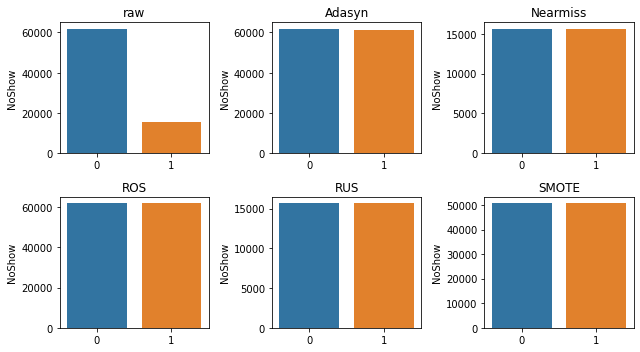

In [6]:
plot_data_distribution([raw_train, Adasyn_train, Nearmiss_train, ROS_train, RUS_train, SMOTETomek_train], ['raw', 'Adasyn', 'Nearmiss', 'ROS', 'RUS', 'SMOTE'])

## Models

In [7]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

In [8]:
def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

In [9]:
def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred)
    return score

In [10]:
def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 7, scoring = scoring)
    return np.mean(scores), np.std(scores)

In [6]:
def split_data(train, test):
    feats = train.columns[:-1]
    
    X_train = train[feats]
    X_test = test[feats]
    
    y_train = train['NoShow']
    y_test = test["NoShow"]
    return X_train, y_train, X_test, y_test

In [12]:
metrics = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
}

models = {
    'XGB': xgb.XGBClassifier(),
    'LGBM': lgb.LGBMClassifier(),
    'CTB': ctb.CatBoostClassifier(verbose=0),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'HistGradientBoosting': HistGradientBoostingClassifier(),
}

In [13]:
def run_model(model, train, test, name, tags):
    X_train, y_train, X_test, y_test = split_data(train, test)
    
    neptune.create_experiment(
        name=name
    )
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    print('ROC AUC: ', roc,'\n')
    print(classification_report(y_test, y_pred))
    
    neptune.log_metric('accuracy', accuracy)
    neptune.log_metric('recall', recall)
    neptune.log_metric('precision', precision)
    neptune.log_metric('f1', f1)
    neptune.log_metric('roc_auc', roc)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags(["Jędrzej Dudzicz"])
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    plot_learning_curve(model, X_test, y_test, scoring='f1');    
    plt.show()
    neptune.stop()

Raw Data
XGB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-143
[1 0 0 ... 0 0 0] 

accuracy:  0.7989306767810629
recall:  0.06722498868266184
precision:  0.515625
f1:  0.11894273127753306
ROC AUC:  0.525625090963146 

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     17465
           1       0.52      0.07      0.12      4418

    accuracy                           0.80     21883
   macro avg       0.66      0.53      0.50     21883
weighted avg       0.75      0.80      0.73     21883



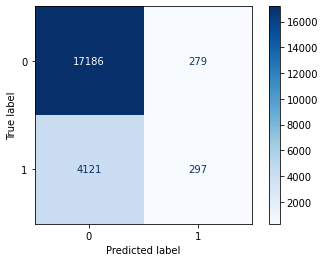

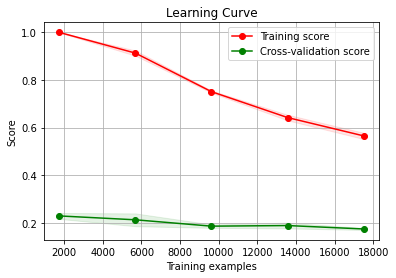

LGBM


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-144
[0 0 0 ... 0 0 0] 

accuracy:  0.7999360233971576
recall:  0.01765504753282028
precision:  0.6724137931034483
f1:  0.03440670489633878
ROC AUC:  0.5077396337005642 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17465
           1       0.67      0.02      0.03      4418

    accuracy                           0.80     21883
   macro avg       0.74      0.51      0.46     21883
weighted avg       0.77      0.80      0.72     21883



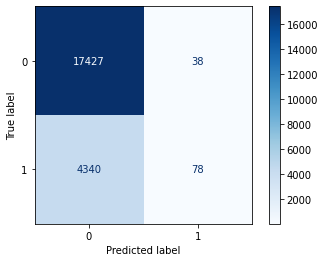

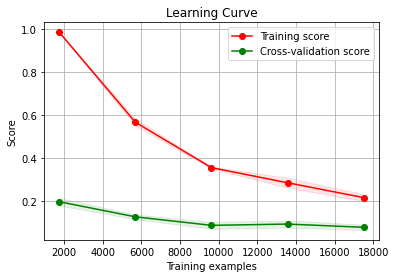

CTB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-145
[0 0 0 ... 0 0 0] 

accuracy:  0.7999817209706165
recall:  0.05862381167949298
precision:  0.5429769392033543
f1:  0.10582226762002042
ROC AUC:  0.5230708523041039 

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     17465
           1       0.54      0.06      0.11      4418

    accuracy                           0.80     21883
   macro avg       0.67      0.52      0.50     21883
weighted avg       0.75      0.80      0.73     21883



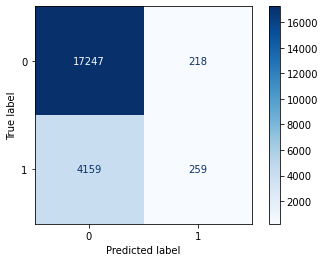

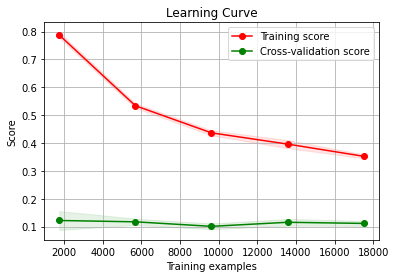

AdaBoost


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-146
[0 0 0 ... 0 0 0] 

accuracy:  0.7982452131791802
recall:  0.007922136713444997
precision:  0.5223880597014925
f1:  0.015607580824972128
ROC AUC:  0.5030449504065364 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17465
           1       0.52      0.01      0.02      4418

    accuracy                           0.80     21883
   macro avg       0.66      0.50      0.45     21883
weighted avg       0.74      0.80      0.71     21883



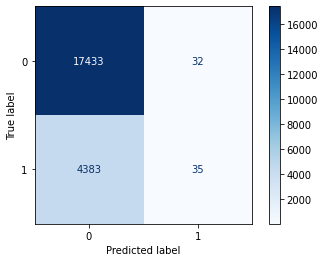

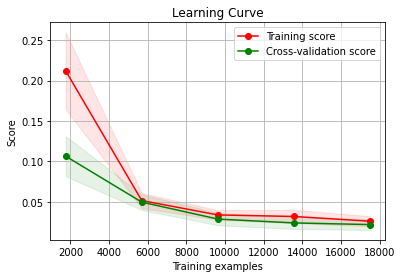

GradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-147
[0 0 0 ... 0 0 0] 

accuracy:  0.7984737010464744
recall:  0.0047532820280669985
precision:  0.6176470588235294
f1:  0.009433962264150943
ROC AUC:  0.5020044680967704 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17465
           1       0.62      0.00      0.01      4418

    accuracy                           0.80     21883
   macro avg       0.71      0.50      0.45     21883
weighted avg       0.76      0.80      0.71     21883



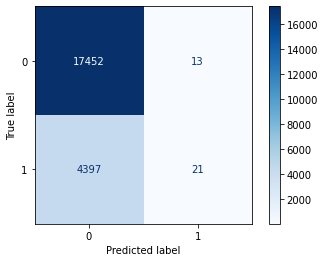

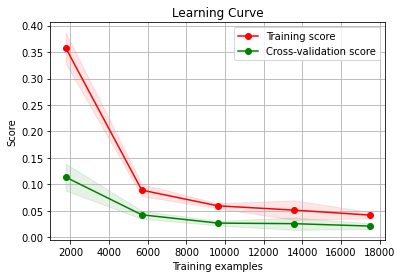

HistGradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-148
[0 0 0 ... 0 0 0] 

accuracy:  0.7996618379564046
recall:  0.01923947487550928
precision:  0.625
f1:  0.03732981993851559
ROC AUC:  0.5081596744546456 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17465
           1       0.62      0.02      0.04      4418

    accuracy                           0.80     21883
   macro avg       0.71      0.51      0.46     21883
weighted avg       0.77      0.80      0.72     21883



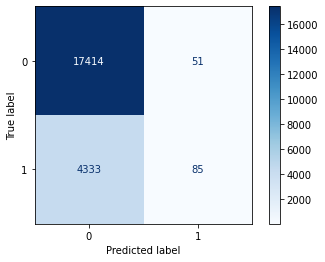

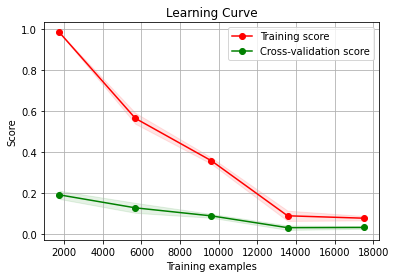

In [236]:
name = "Raw Data"
print(name)

for model in models.items():
    print(model[0])
    run_model(model[1], raw_train, raw_test, model[0], name)


Adasyn
XGB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-149
[0 0 0 ... 1 1 1] 

accuracy:  0.8573432177920256
recall:  0.77621336996337
precision:  0.926619294889314
f1:  0.8447738881275696
ROC AUC:  0.8573594762785643 

              precision    recall  f1-score   support

           0       0.81      0.94      0.87     17465
           1       0.93      0.78      0.84     17472

    accuracy                           0.86     34937
   macro avg       0.87      0.86      0.86     34937
weighted avg       0.87      0.86      0.86     34937



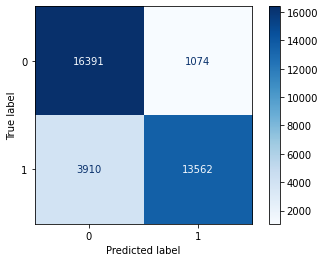

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


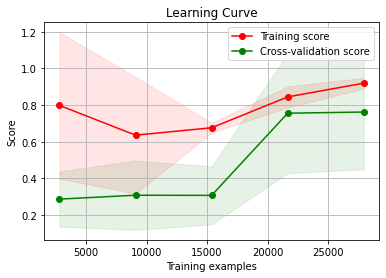

LGBM


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-150
[0 0 0 ... 1 1 1] 

accuracy:  0.8586312505366803
recall:  0.761790293040293
precision:  0.9448427628309789
f1:  0.8434994771697456
ROC AUC:  0.8586506575421905 

              precision    recall  f1-score   support

           0       0.80      0.96      0.87     17465
           1       0.94      0.76      0.84     17472

    accuracy                           0.86     34937
   macro avg       0.87      0.86      0.86     34937
weighted avg       0.87      0.86      0.86     34937



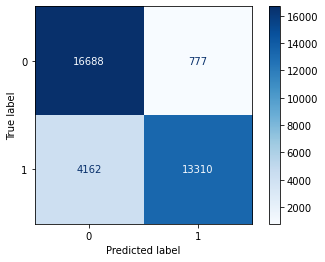

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


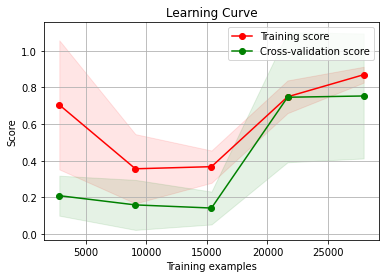

CTB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-151
[1 0 0 ... 1 1 1] 

accuracy:  0.8603772504794344
recall:  0.7710622710622711
precision:  0.938815331010453
f1:  0.8467098233926215
ROC AUC:  0.8603951492729047 

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     17465
           1       0.94      0.77      0.85     17472

    accuracy                           0.86     34937
   macro avg       0.87      0.86      0.86     34937
weighted avg       0.87      0.86      0.86     34937



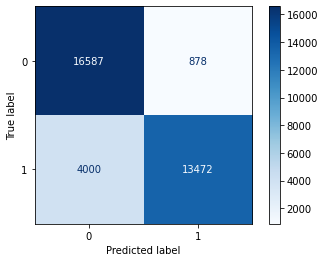

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1743, in _fit
    train_params["init_model"]
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1230, in _train
    self

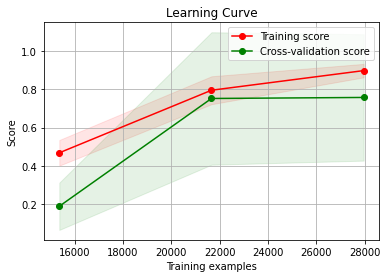

AdaBoost


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-152
[1 0 0 ... 1 1 1] 

accuracy:  0.81526748146664
recall:  0.8185096153846154
precision:  0.8132961783439491
f1:  0.8158945686900959
ROC AUC:  0.8152668317404039 

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     17465
           1       0.81      0.82      0.82     17472

    accuracy                           0.82     34937
   macro avg       0.82      0.82      0.82     34937
weighted avg       0.82      0.82      0.82     34937



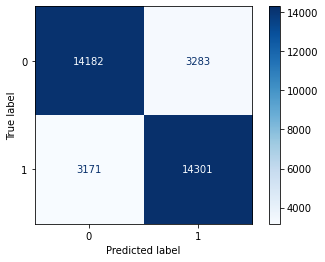

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


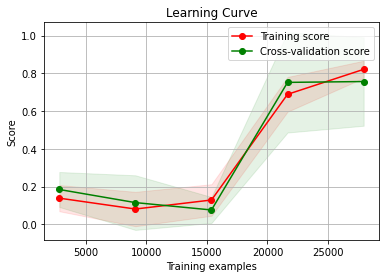

GradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-153
[0 0 0 ... 1 1 1] 

accuracy:  0.8402839396628217
recall:  0.7831387362637363
precision:  0.884257464133385
f1:  0.8306319431797488
ROC AUC:  0.8402953916073906 

              precision    recall  f1-score   support

           0       0.81      0.90      0.85     17465
           1       0.88      0.78      0.83     17472

    accuracy                           0.84     34937
   macro avg       0.84      0.84      0.84     34937
weighted avg       0.84      0.84      0.84     34937



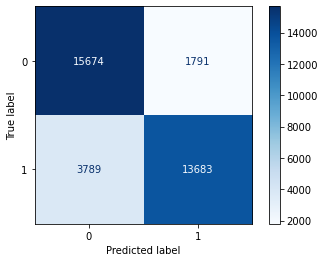

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 418, in fit
    y = self._validate_y(y, sample_weight)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 1104, in _validate_y
    % n_trim_classes)
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

  FitFailedWarning)
/Library/Frameworks/Python

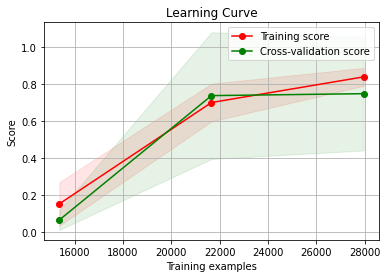

HistGradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-154
[0 0 0 ... 1 1 1] 

accuracy:  0.8570283653433323
recall:  0.7610462454212454
precision:  0.941914004391868
f1:  0.8418753363512617
ROC AUC:  0.8570476002371042 

              precision    recall  f1-score   support

           0       0.80      0.95      0.87     17465
           1       0.94      0.76      0.84     17472

    accuracy                           0.86     34937
   macro avg       0.87      0.86      0.86     34937
weighted avg       0.87      0.86      0.86     34937



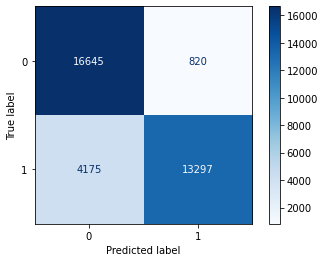

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


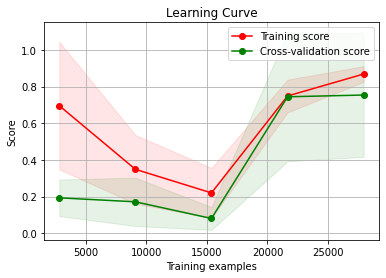

In [237]:
name = "Adasyn"
print(name)
for model in models.items():
    print(model[0])
    run_model(model[1], Adasyn_train, Adasyn_test, model[0], name)

Nearmiss
XGB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-155
[1 1 1 ... 0 1 1] 

accuracy:  0.7988909008601177
recall:  0.7634676324128565
precision:  0.8216808769792936
f1:  0.7915053384958348
ROC AUC:  0.7988909008601178 

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      4418
           1       0.82      0.76      0.79      4418

    accuracy                           0.80      8836
   macro avg       0.80      0.80      0.80      8836
weighted avg       0.80      0.80      0.80      8836



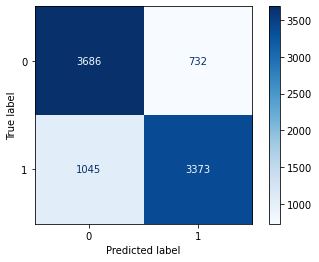

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


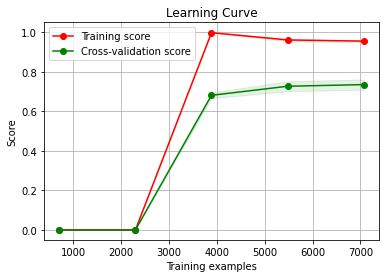

LGBM


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-156
[1 1 1 ... 0 1 0] 

accuracy:  0.8029651425984609
recall:  0.751923947487551
precision:  0.8374086211242753
f1:  0.7923673225998809
ROC AUC:  0.8029651425984609 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      4418
           1       0.84      0.75      0.79      4418

    accuracy                           0.80      8836
   macro avg       0.81      0.80      0.80      8836
weighted avg       0.81      0.80      0.80      8836



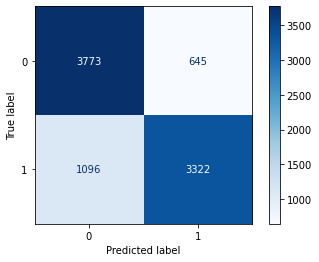

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


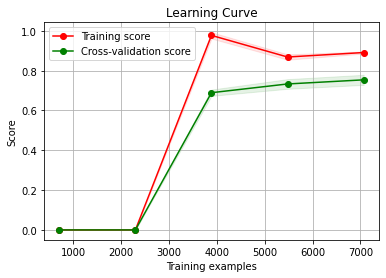

CTB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-157
[0 1 1 ... 1 0 0] 

accuracy:  0.8063603440470801
recall:  0.763014938886374
precision:  0.8354399008674102
f1:  0.7975866556252219
ROC AUC:  0.8063603440470801 

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      4418
           1       0.84      0.76      0.80      4418

    accuracy                           0.81      8836
   macro avg       0.81      0.81      0.81      8836
weighted avg       0.81      0.81      0.81      8836



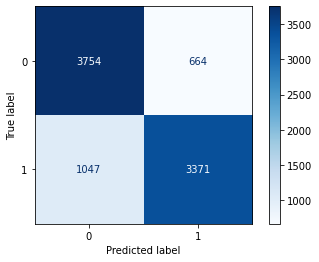

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1743, in _fit
    train_params["init_model"]
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1230, in _train
    self

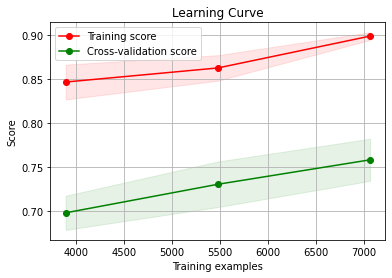

AdaBoost


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-158
[0 0 1 ... 0 0 0] 

accuracy:  0.7997962879130829
recall:  0.7473970122227253
precision:  0.8348925410872313
f1:  0.7887256658306462
ROC AUC:  0.7997962879130829 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      4418
           1       0.83      0.75      0.79      4418

    accuracy                           0.80      8836
   macro avg       0.80      0.80      0.80      8836
weighted avg       0.80      0.80      0.80      8836



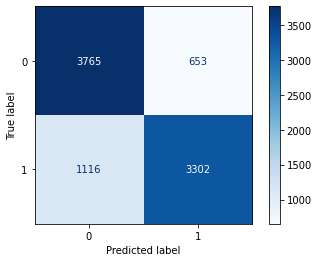

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

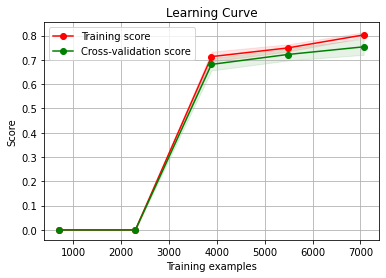

GradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-159
[0 0 1 ... 0 1 0] 

accuracy:  0.7996831145314622
recall:  0.7516976007243097
precision:  0.8314972458688032
f1:  0.7895863052781741
ROC AUC:  0.7996831145314622 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      4418
           1       0.83      0.75      0.79      4418

    accuracy                           0.80      8836
   macro avg       0.80      0.80      0.80      8836
weighted avg       0.80      0.80      0.80      8836



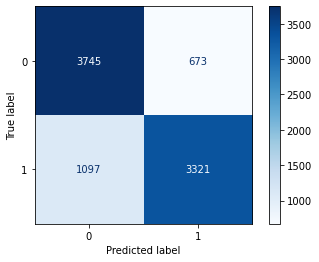

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 418, in fit
    y = self._validate_y(y, sample_weight)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 1104, in _validate_y
    % n_trim_classes)
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

  FitFailedWarning)
/Library/Frameworks/Python

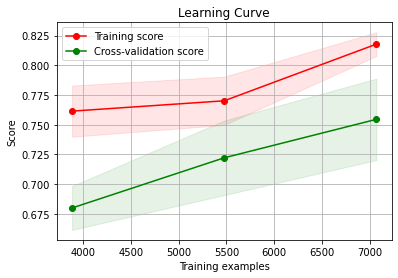

HistGradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-160
[1 1 1 ... 0 1 0] 

accuracy:  0.8005885015844273
recall:  0.7514712539610684
precision:  0.8333333333333334
f1:  0.7902880266603192
ROC AUC:  0.8005885015844274 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      4418
           1       0.83      0.75      0.79      4418

    accuracy                           0.80      8836
   macro avg       0.80      0.80      0.80      8836
weighted avg       0.80      0.80      0.80      8836



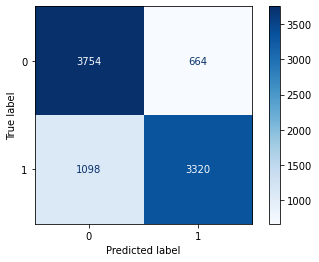

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

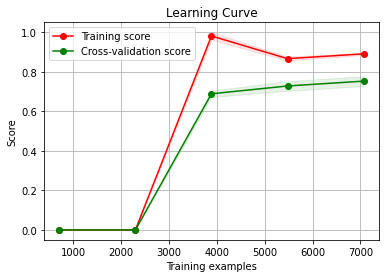

In [238]:
name= 'Nearmiss'
print(name)
for model in models.items():
    print(model[0])
    run_model(model[1], Nearmiss_train, Nearmiss_test, model[0], name)

ROS
XGB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-161
[1 0 0 ... 1 0 0] 

accuracy:  0.6717434869739479
recall:  0.732150014314343
precision:  0.6532311621966794
f1:  0.6904427645788337
ROC AUC:  0.6717434869739479 

              precision    recall  f1-score   support

           0       0.70      0.61      0.65     17465
           1       0.65      0.73      0.69     17465

    accuracy                           0.67     34930
   macro avg       0.67      0.67      0.67     34930
weighted avg       0.67      0.67      0.67     34930



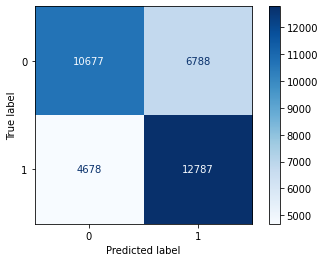

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


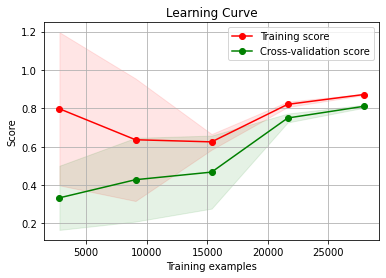

LGBM


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-162
[1 0 0 ... 1 1 1] 

accuracy:  0.6782135699971371
recall:  0.8103635843114801
precision:  0.6409582899325211
f1:  0.7157740353006625
ROC AUC:  0.6782135699971372 

              precision    recall  f1-score   support

           0       0.74      0.55      0.63     17465
           1       0.64      0.81      0.72     17465

    accuracy                           0.68     34930
   macro avg       0.69      0.68      0.67     34930
weighted avg       0.69      0.68      0.67     34930



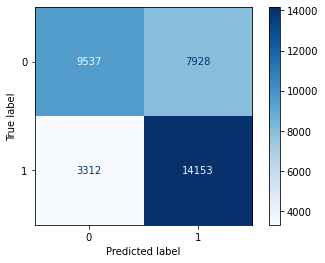

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


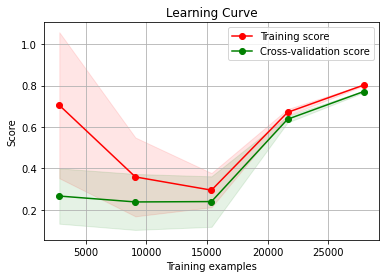

CTB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-163
[1 0 0 ... 1 0 0] 

accuracy:  0.6764958488405383
recall:  0.7370168909247066
precision:  0.6574390929056643
f1:  0.6949573480185726
ROC AUC:  0.6764958488405383 

              precision    recall  f1-score   support

           0       0.70      0.62      0.66     17465
           1       0.66      0.74      0.69     17465

    accuracy                           0.68     34930
   macro avg       0.68      0.68      0.68     34930
weighted avg       0.68      0.68      0.68     34930



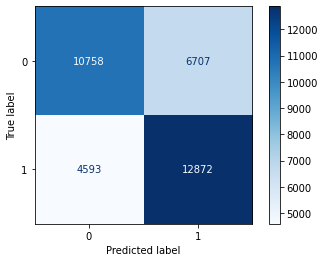

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1743, in _fit
    train_params["init_model"]
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1230, in _train
    self

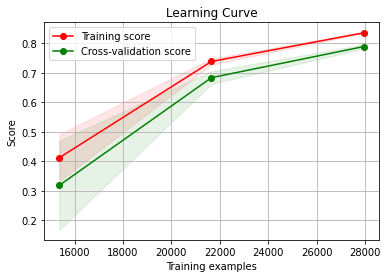

AdaBoost


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-164
[1 0 1 ... 1 1 1] 

accuracy:  0.6715144574864014
recall:  0.8152877182937304
precision:  0.6332102992840307
f1:  0.7128053664397276
ROC AUC:  0.6715144574864014 

              precision    recall  f1-score   support

           0       0.74      0.53      0.62     17465
           1       0.63      0.82      0.71     17465

    accuracy                           0.67     34930
   macro avg       0.69      0.67      0.66     34930
weighted avg       0.69      0.67      0.66     34930



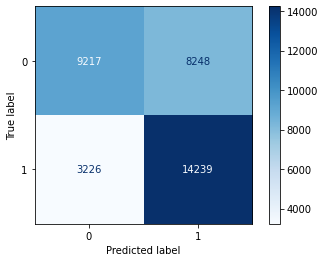

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


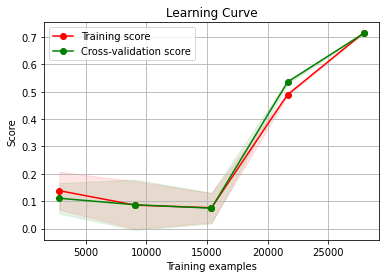

GradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-165
[1 0 0 ... 1 1 1] 

accuracy:  0.672115659891211
recall:  0.8222731176638992
precision:  0.6323645970937913
f1:  0.7149222153080275
ROC AUC:  0.6721156598912109 

              precision    recall  f1-score   support

           0       0.75      0.52      0.61     17465
           1       0.63      0.82      0.71     17465

    accuracy                           0.67     34930
   macro avg       0.69      0.67      0.66     34930
weighted avg       0.69      0.67      0.66     34930



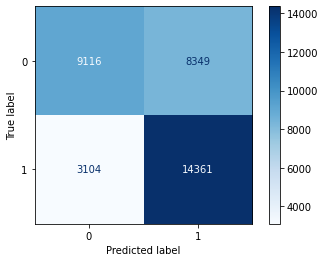

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 418, in fit
    y = self._validate_y(y, sample_weight)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 1104, in _validate_y
    % n_trim_classes)
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

  FitFailedWarning)
/Library/Frameworks/Python

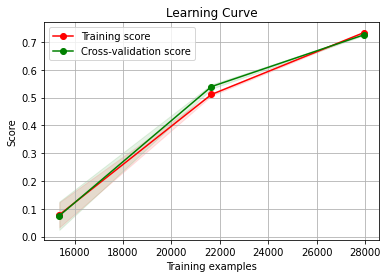

HistGradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-166
[1 0 0 ... 1 1 1] 

accuracy:  0.6774405954766676
recall:  0.8096192384769539
precision:  0.6403405488633276
f1:  0.7150984904038232
ROC AUC:  0.6774405954766676 

              precision    recall  f1-score   support

           0       0.74      0.55      0.63     17465
           1       0.64      0.81      0.72     17465

    accuracy                           0.68     34930
   macro avg       0.69      0.68      0.67     34930
weighted avg       0.69      0.68      0.67     34930



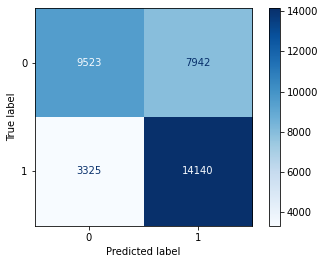

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


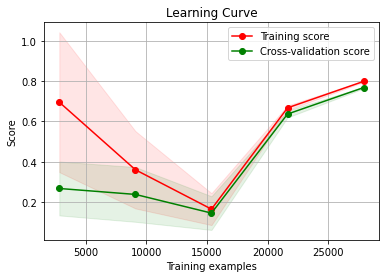

In [239]:
name = 'ROS'
print(name)
for model in models.items():
    print(model[0])
    run_model(model[1], ROS_train, ROS_test, model[0], name)

RUS
XGB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-167
[1 1 0 ... 1 1 1] 

accuracy:  0.6714576731552738
recall:  0.7840651878678135
precision:  0.6399408830593016
f1:  0.7047095921066014
ROC AUC:  0.6714576731552739 

              precision    recall  f1-score   support

           0       0.72      0.56      0.63      4418
           1       0.64      0.78      0.70      4418

    accuracy                           0.67      8836
   macro avg       0.68      0.67      0.67      8836
weighted avg       0.68      0.67      0.67      8836



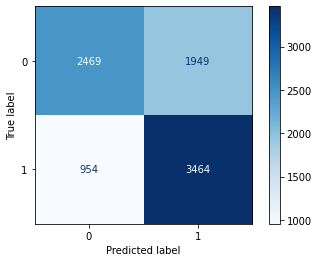

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


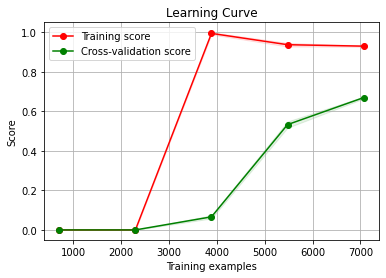

LGBM


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-168
[1 1 0 ... 1 1 1] 

accuracy:  0.6783612494341331
recall:  0.8318243549117248
precision:  0.6364738482854174
f1:  0.7211538461538461
ROC AUC:  0.6783612494341331 

              precision    recall  f1-score   support

           0       0.76      0.52      0.62      4418
           1       0.64      0.83      0.72      4418

    accuracy                           0.68      8836
   macro avg       0.70      0.68      0.67      8836
weighted avg       0.70      0.68      0.67      8836



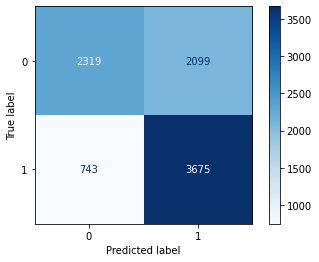

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


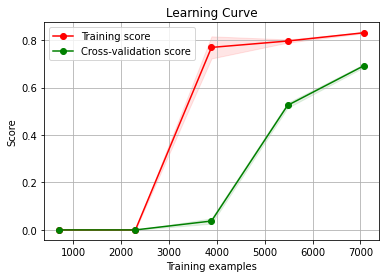

CTB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-169
[1 1 1 ... 1 1 1] 

accuracy:  0.6702127659574468
recall:  0.8003621548211861
precision:  0.6350574712643678
f1:  0.7081914680552773
ROC AUC:  0.6702127659574468 

              precision    recall  f1-score   support

           0       0.73      0.54      0.62      4418
           1       0.64      0.80      0.71      4418

    accuracy                           0.67      8836
   macro avg       0.68      0.67      0.66      8836
weighted avg       0.68      0.67      0.66      8836



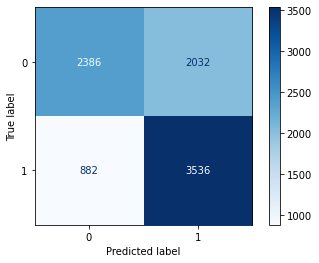

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1743, in _fit
    train_params["init_model"]
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1230, in _train
    self

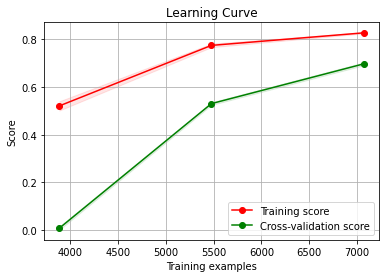

AdaBoost


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-170
[1 1 1 ... 1 1 1] 

accuracy:  0.6679492983250339
recall:  0.8173381620642824
precision:  0.6293133495991635
f1:  0.7111067349350139
ROC AUC:  0.6679492983250339 

              precision    recall  f1-score   support

           0       0.74      0.52      0.61      4418
           1       0.63      0.82      0.71      4418

    accuracy                           0.67      8836
   macro avg       0.68      0.67      0.66      8836
weighted avg       0.68      0.67      0.66      8836



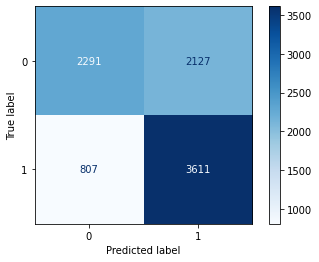

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

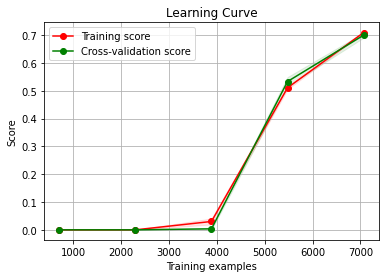

GradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-171
[1 1 1 ... 1 1 1] 

accuracy:  0.6687415119963784
recall:  0.8245812584880037
precision:  0.6286453839516825
f1:  0.7134044844805639
ROC AUC:  0.6687415119963784 

              precision    recall  f1-score   support

           0       0.75      0.51      0.61      4418
           1       0.63      0.82      0.71      4418

    accuracy                           0.67      8836
   macro avg       0.69      0.67      0.66      8836
weighted avg       0.69      0.67      0.66      8836



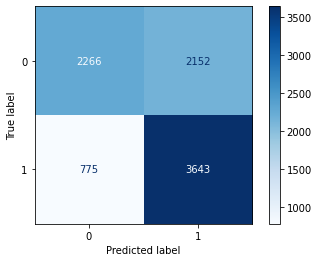

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 418, in fit
    y = self._validate_y(y, sample_weight)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 1104, in _validate_y
    % n_trim_classes)
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

  FitFailedWarning)
/Library/Frameworks/Python

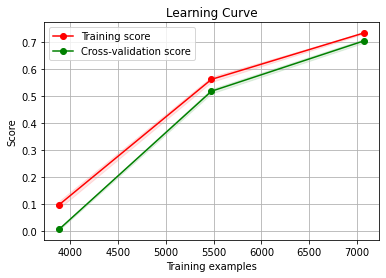

HistGradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-172
[1 1 1 ... 1 1 1] 

accuracy:  0.6748528746038932
recall:  0.8334087822544137
precision:  0.632754768860629
f1:  0.7193513724724039
ROC AUC:  0.6748528746038931 

              precision    recall  f1-score   support

           0       0.76      0.52      0.61      4418
           1       0.63      0.83      0.72      4418

    accuracy                           0.67      8836
   macro avg       0.69      0.67      0.67      8836
weighted avg       0.69      0.67      0.67      8836



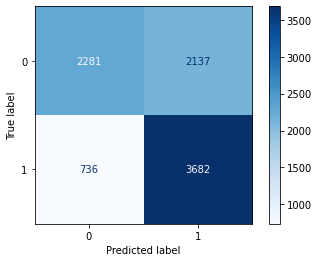

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F

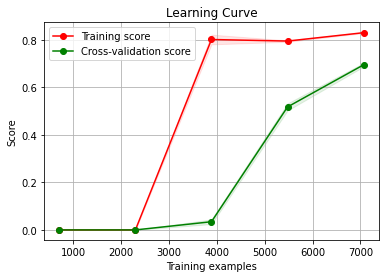

In [240]:
name = 'RUS'
print(name)
for model in models.items():
    print(model[0])
    run_model(model[1], RUS_train, RUS_test, model[0], name)

SMOTETomek
XGB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-173
[0 0 0 ... 1 1 1] 

accuracy:  0.8725954424385913
recall:  0.7978691920686594
precision:  0.9380654140570633
f1:  0.8623060930753237
ROC AUC:  0.8725954424385913 

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     13516
           1       0.94      0.80      0.86     13516

    accuracy                           0.87     27032
   macro avg       0.88      0.87      0.87     27032
weighted avg       0.88      0.87      0.87     27032



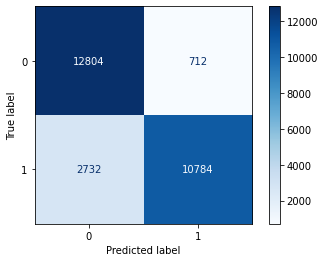

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


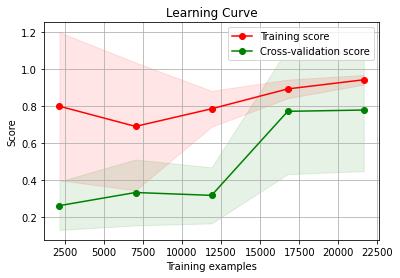

LGBM


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-174
[0 0 0 ... 1 1 1] 

accuracy:  0.8742971293282036
recall:  0.7902485942586565
precision:  0.9499288509427251
f1:  0.862762520193861
ROC AUC:  0.8742971293282037 

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     13516
           1       0.95      0.79      0.86     13516

    accuracy                           0.87     27032
   macro avg       0.89      0.87      0.87     27032
weighted avg       0.89      0.87      0.87     27032



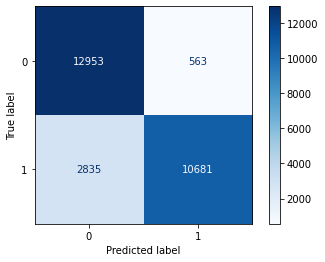

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


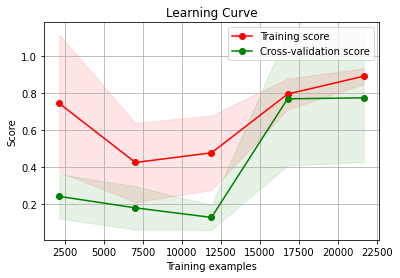

CTB


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-175
[0 0 0 ... 1 1 1] 

accuracy:  0.8768126664693696
recall:  0.7974992601361349
precision:  0.9478543791769258
f1:  0.8662005785920925
ROC AUC:  0.8768126664693697 

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     13516
           1       0.95      0.80      0.87     13516

    accuracy                           0.88     27032
   macro avg       0.89      0.88      0.88     27032
weighted avg       0.89      0.88      0.88     27032



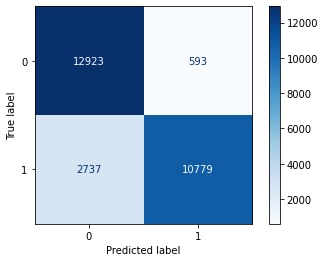

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1743, in _fit
    train_params["init_model"]
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1230, in _train
    self

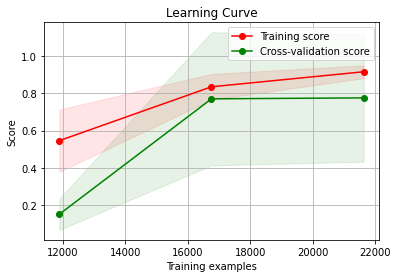

AdaBoost


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-176
[1 0 0 ... 1 1 1] 

accuracy:  0.8330867120449837
recall:  0.8357502219591595
precision:  0.8313217544892553
f1:  0.833530106257379
ROC AUC:  0.8330867120449836 

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     13516
           1       0.83      0.84      0.83     13516

    accuracy                           0.83     27032
   macro avg       0.83      0.83      0.83     27032
weighted avg       0.83      0.83      0.83     27032



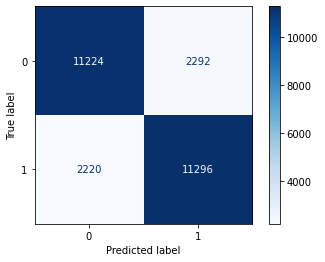

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


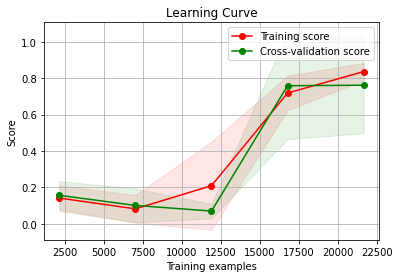

GradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-177
[1 0 0 ... 1 1 1] 

accuracy:  0.8575762059781
recall:  0.799348919798757
precision:  0.9047060793836879
f1:  0.8487705240003142
ROC AUC:  0.8575762059781 

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     13516
           1       0.90      0.80      0.85     13516

    accuracy                           0.86     27032
   macro avg       0.86      0.86      0.86     27032
weighted avg       0.86      0.86      0.86     27032



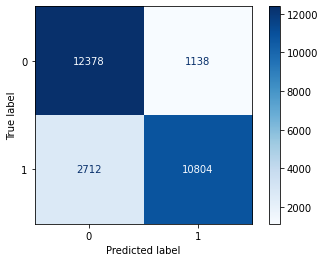

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 418, in fit
    y = self._validate_y(y, sample_weight)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 1104, in _validate_y
    % n_trim_classes)
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

  FitFailedWarning)
/Library/Frameworks/Python

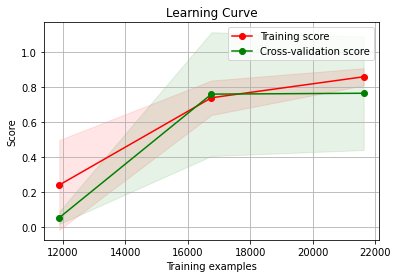

HistGradientBoosting


psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-178
[0 0 0 ... 1 1 1] 

accuracy:  0.8742231429416987
recall:  0.7888428529150636
precision:  0.9512847965738758
f1:  0.8624817990616405
ROC AUC:  0.8742231429416988 

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     13516
           1       0.95      0.79      0.86     13516

    accuracy                           0.87     27032
   macro avg       0.89      0.87      0.87     27032
weighted avg       0.89      0.87      0.87     27032



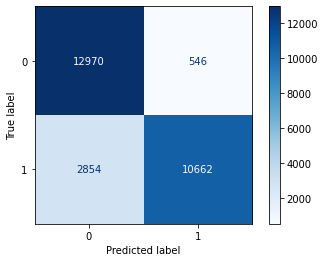

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


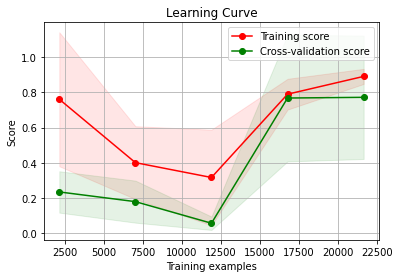

In [241]:
name = 'SMOTETomek'
print(name)
for model in models.items():
    print(model[0])
    table = run_model(model[1], SMOTETomek_train, SMOTETomek_test, model[0], name)

## SMOTE hyperopt


In [28]:
def hyperopt():
    trials = Trials()
    
    space ={
        'depth': hp.quniform ('depth', 2, 7, 1),
        'learning_rate': hp.uniform ('learning_rate', 0.01, 0.5),
        'subsample': hp.uniform ('subsample', 0.8, 1.),
        'reg_lambda': hp.uniform ('reg_lambda', 0.7, 1.),
        'n_estimators': hp.quniform ('n_estimators', 10, 600, 1),
        'random_state': 2021,
        'verbose': 0,
    }
    
    best_params = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=1),
                max_evals=60,
                trials=trials)

    print("The best params: ", best_params)
    return trials.best_trial

def objective(space):
    
    params = {
        'depth': int(space['depth']),
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'random_state': int(space['random_state']),
        'verbose': int(space['verbose']),
    }
    
    model = ctb.CatBoostClassifier(**params)
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    score = score_model(y_test, y_pred, f1_score)
    
    return{'loss': -score, 'status': STATUS_OK }
    

In [29]:
X_train, y_train, X_test, y_test = split_data(SMOTETomek_train, SMOTETomek_test)
hyperopt() # CTB

100%|██████████| 60/60 [06:59<00:00,  6.99s/trial, best loss: -0.8666854000240857]
The best params:  {'depth': 7.0, 'learning_rate': 0.11334733253283154, 'n_estimators': 399.0, 'reg_lambda': 0.8271222322249208, 'subsample': 0.8312830453940667}


{'state': 2,
 'tid': 50,
 'spec': None,
 'result': {'loss': -0.8666854000240857, 'status': 'ok'},
 'misc': {'tid': 50,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'depth': [50],
   'learning_rate': [50],
   'n_estimators': [50],
   'reg_lambda': [50],
   'subsample': [50]},
  'vals': {'depth': [7.0],
   'learning_rate': [0.11334733253283154],
   'n_estimators': [399.0],
   'reg_lambda': [0.8271222322249208],
   'subsample': [0.8312830453940667]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 1, 1, 10, 31, 9, 384000),
 'refresh_time': datetime.datetime(2021, 1, 1, 10, 31, 20, 707000)}

psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-185
[0 0 0 ... 1 1 1] 

accuracy:  0.8771456052086416
recall:  0.798683042320213
precision:  0.9473453268977622
f1:  0.8666854000240857
ROC AUC:  0.8771456052086417 

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     13516
           1       0.95      0.80      0.87     13516

    accuracy                           0.88     27032
   macro avg       0.89      0.88      0.88     27032
weighted avg       0.89      0.88      0.88     27032



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 4115, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1743, in _fit
    train_params["init_model"]
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/catboost/core.py", line 1230, in _train
    self

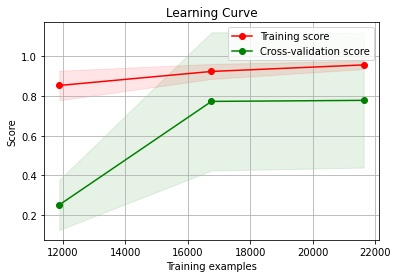

In [32]:
best_Smote_params = {
    'depth': 7,
    'learning_rate': 0.11334733253283154,
    'n_estimators': 399,
    'reg_lambda': 0.8271222322249208,
    'subsample': 0.8312830453940667,
    'random_state': 2021,
    'verbose': 0,
}
model = ctb.CatBoostClassifier(**best_Smote_params)
model = train_model(model, X_train, y_train)
y_pred = predict_model(model, X_test)

neptune.create_experiment(
        name='SmoteTomek'
    )
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

print(y_pred,'\n')
print('accuracy: ', accuracy)
print('recall: ',recall)
print('precision: ', precision)
print('f1: ', f1)
print('ROC AUC: ', roc,'\n')
print(classification_report(y_test, y_pred))

neptune.log_metric('accuracy', accuracy)
neptune.log_metric('recall', recall)
neptune.log_metric('precision', precision)
neptune.log_metric('f1', f1)
neptune.log_metric('roc_auc', roc)
neptune.append_tags('catboost')
neptune.append_tags('SmoteTomek')
neptune.append_tags('hyperopt')
neptune.append_tags([str(best_Smote_params)])
neptune.append_tags(["Jędrzej Dudzicz"])
    
plot_learning_curve(model, X_test, y_test, scoring='f1');
neptune.stop()

In [20]:
best_Smote_params = {
    'depth': 7,
    'learning_rate': 0.11334733253283154,
    'n_estimators': 399,
    'reg_lambda': 0.8271222322249208,
    'subsample': 0.8312830453940667,
    'random_state': 2021,
    'verbose': 0,
}
X_train, y_train, X_test, y_test = split_data(SMOTETomek_train, SMOTETomek_test)
model = ctb.CatBoostClassifier(**best_Smote_params)

model.fit(X_train, y_train)

imp = PermutationImportance(model, random_state = 2021).fit(X_train, y_train)
eli5.show_weights(imp, feature_names = X_train.columns.values, top = 50)

Weight,Feature
0.1033 ± 0.0007,AppointmentWeekDay_2
0.0941 ± 0.0016,MonthBookingDate_1
0.0862 ± 0.0014,DaysToAppointment
0.0854 ± 0.0012,DayAppointmentDate_1
0.0823 ± 0.0009,MonthAppointmentDate_2
0.0781 ± 0.0009,DayAppointmentDate_2
0.0715 ± 0.0014,DayAppointmentDate_4
0.0695 ± 0.0009,DayAppointmentDate_3
0.0674 ± 0.0011,AppointmentWeekDay_3
0.0509 ± 0.0014,AppointmentWeekDay_1
